# Principal component analysis - does higher explained variance mean more predictive power?

### Why?
In the course of studying data science I have come across this notion many times: In a prediction task, when you want to reduce the dimensionality of your data, do PCA. Keep the principal components(PCs) with the highest explained variance and use them as features. This way with a limited number of dimensions, we retain the most information in our dataset, (implying that) and thus the most predictive power of the features.

The first half is pretty straightforward. But if once we talk about predictive power, I have always wondered how retaining variance translates to retaining predictive power. I've checked online courses, asked instructors and friends, and couldn't find a compelling answer.


### The imaginary horse data
Below is an artificial dataset to illustrate my point:
We have 1000 observations of 4 variables. Each observation is a horse, and the variables are 
1. `horse_weight` -- weight of the horse. Just to illustrate the point, not used in the model.
2. `muscle_mass` -- mass of the muscles of the horse. (Don't ask how it was measured, it's all made up to illustrate the point)
3. `bone_mass` -- mass of the horse's bones.
4. `km_time` -- The time it takes for the horse to run 1 km. Target variable.

Suppose we want to predict how fast a horse can run a kilometer just by it's bone and muscle masses, and for some really weird reason we can only use one feature in our model. So we decide to do PCA and use the first PC as our feature, and end up with a model that has no predictive power at all -- worse than if we had used only either of `bone_mass` or `muscle_mass`. And more importantly, or model performs much worse than if we had used the *second* PC from the PCA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import model_selection

In [2]:
# constants to adjust how the artificial dataset is generate
VAR = 0.05
WEIGHT_BASE = 500
MUSCLE_BASE = 0.4
BONE_BASE = 0.1
NUM_HORSES = 1000
TIME_BASE = 56
sns.set(rc={'figure.figsize':(6 ,6)})

In [3]:
# create an array with random numbers for the noise
ls = []
for i in range(NUM_HORSES*4):
    ls.append(np.random.normal(1, VAR))
ran = np.array(ls)
np.set_printoptions(suppress=True)
ran = np.reshape(ran, [NUM_HORSES, 4])

array([[1.00587077, 1.05129282, 1.03039863, 1.00926927],
       [1.08004213, 1.00343884, 0.96079667, 1.05348816],
       [0.98585277, 1.05462192, 0.92693111, 1.10327883],
       ...,
       [1.06046033, 1.04216428, 1.05572999, 0.98591528],
       [0.93669586, 0.9392602 , 0.99337135, 1.07761896],
       [1.05979162, 1.09175338, 0.99824766, 0.97856915]])

In [4]:
# create df
# ran1 is the variance in `horse_weight`
# ran2 is the variance in the proportion of muscle the horse is out of his 
#     whole body
# ran3 is the variance in the proportion of bones the horse is out of his 
#     whole body
# ran4 is the variance in the horse's speed
df = pd.DataFrame(ran, columns=['ran1', 'ran2', 'ran3', 'ran4'])
df['horse_weight'] = WEIGHT_BASE * df.ran1
df['muscle_mass'] = df.horse_weight * MUSCLE_BASE * df.ran2
df['bone_mass'] = df.horse_weight * BONE_BASE * df.ran3
df['km_time'] = (
    TIME_BASE / (df.ran2**0.2) * (df.ran3**0.25) * ((df.ran4)**0.1)
)
df = df[['horse_weight', 'muscle_mass', 'bone_mass', 'km_time']]
df.describe()

,horse_weight,muscle_mass,bone_mass,km_time
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.554750,200.179182,50.001697,55.975357
std,25.240129,14.387096,3.596956,0.937561
min,421.937686,156.671112,41.126406,53.112799
25%,482.956531,190.403900,47.561455,55.314435
50%,500.087038,199.403811,49.923270,55.969163
75%,517.456291,209.545033,52.271029,56.594475
max,578.064167,245.653446,61.737707,58.790328


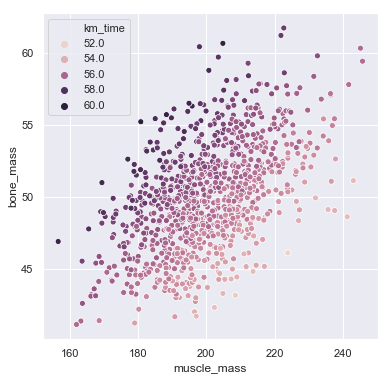

In [5]:
sns.scatterplot(df.muscle_mass, df.bone_mass, hue=df.km_time)
plt.show()

Here we can see that `bone_mass` is positively correlated with `muscle_mass` -- the bigger the horse, the more muscles and bone volume it'll have.

But horse speed is actually helped by having more muscles and less bones -- more power carrying less weight. So we can see as we move from the top left to the bottom right of the chart, the horses get faster.

### PCA

Explained variance:
First PC (red): 210.6920444898985
Second PC (turquoise): 9.23457295507972


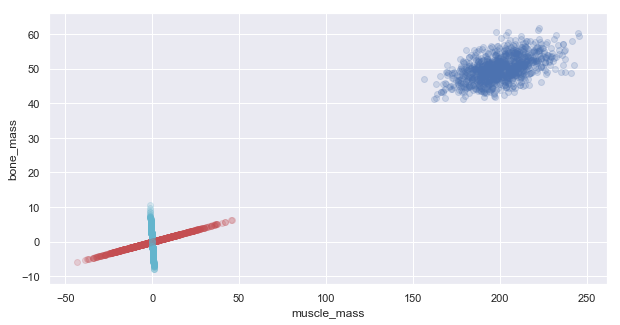

In [6]:
data = np.array(df[['muscle_mass', 'bone_mass']])

def doPCA():
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(data)
    return pca

pca = doPCA()
first_pc = pca.components_[0]
second_pc = pca.components_[1]
transformed_data = pca.transform(data)
plt.figure(figsize=(10, 5))
for ii, jj in zip(transformed_data, data):
    plt.scatter(first_pc[0]*ii[0], first_pc[1]*ii[0], color='r', alpha=0.2)
    plt.scatter(second_pc[0]*ii[1], second_pc[1]*ii[1], color='c', alpha=0.2)
    plt.scatter(jj[0], jj[1], color='b', alpha=0.2)
    plt.xlabel('muscle_mass')
    plt.ylabel('bone_mass')
print('Explained variance:')
print(f'First PC (red): {pca.explained_variance_[0]}')
print(f'Second PC (turquoise): {pca.explained_variance_[1]}')
plt.show()

The red line is the first PC and the turquoise line the second PC. The first PC essentially captured "how big the horse is" and the second captured something that can be loosely described as "muscle/bone ratio".

In [7]:
transformed_df = pd.DataFrame(transformed_data, columns=['pc1', 'pc2'])
df = pd.concat([df, transformed_df], axis=1)

In [8]:
def do_regression(df, predictor_list, output_var):
    
    df_train, df_test = model_selection.train_test_split(df, random_state=0)
    
    x_train = np.array(df_train[predictor_list])
    y_train = np.array(df_train[output_var]).reshape(-1, 1)
    
    x_test = np.array(df_test[predictor_list])
    y_test = np.array(df_test[output_var]).reshape(-1, 1)   

    rgr = linear_model.LinearRegression()
    rgr.fit(x_train, y_train)
    pred = rgr.predict(x_test)
    r2 = r2_score(y_test, pred)

    print(f'Regression of {output_var} against {predictor_list}')
    print('RMSE: ', (mean_squared_error(y_test, pred))**0.5)
    print('R squared:', (r2))
    print('Coefficients: ', rgr.coef_, '\n\n')
    
    return r2

### Predictive power

Regression of km_time against ['pc1']
RMSE:  0.8116289134263995
R squared: 0.15537196817735532
Coefficients:  [[-0.02516614]] 


Regression of km_time against ['pc2']
RMSE:  0.44445391154454045
R squared: 0.7467182277324936
Coefficients:  [[0.27225719]] 


Regression of km_time against ['pc1', 'pc2']
RMSE:  0.2931390945222876
R squared: 0.8898212210403214
Coefficients:  [[-0.0254979   0.27295639]] 


Regression of km_time against ['muscle_mass']
RMSE:  0.8021669468668339
R squared: 0.17495051603122147
Coefficients:  [[-0.02705406]] 


Regression of km_time against ['bone_mass']
RMSE:  0.7637696234279728
R squared: 0.2520454054171338
Coefficients:  [[0.13731805]] 


Regression of km_time against ['muscle_mass', 'bone_mass']
RMSE:  0.293139094522287
R squared: 0.8898212210403218
Coefficients:  [[-0.06227158  0.26697863]] 




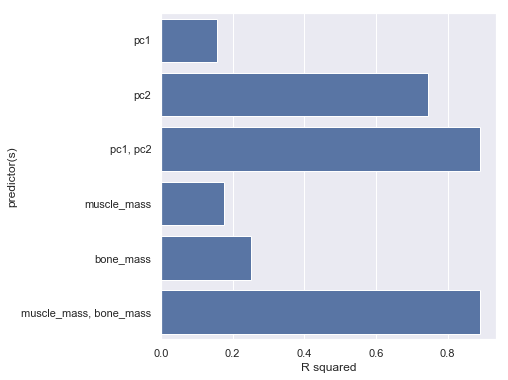

In [9]:
regression_list = [
    ['pc1'],
    ['pc2'],
    ['pc1', 'pc2'],
    ['muscle_mass'],
    ['bone_mass'],
    ['muscle_mass', 'bone_mass']
]

# loop thru the feature combinations
r2s = {}
for elem in regression_list:    
    r2s[', '.join(elem)] = do_regression(df, elem, 'km_time')

r2s = pd.Series(r2s)
fig = sns.barplot(r2s.values, r2s.index,  color='b', orient='h')
fig.set(ylabel='predictor(s)', xlabel='R squared')
plt.show()

As mentioned above, we see that the first PC predicts slightly worse than `muscle_mass` or `bone_mass` alone, and much worse than the second PC. What the first PC captured (horse size / weight) doesn't help much in predicting how fast a horse is, although it better describes the differences between horses than the second PC. 

And the second PC, with it's lower explained variance, happens to capture a big part of the reason why a horse runs fast.

### Moral of the story
I made this dataset up to illustrate the fact that in PCA we try to retain variance as much as possible. But retaining variance doesn't necessarily mean keeping the predictive powers of the features. 

But then, one may argue, that maybe top PCs do have better predictive power in most cases in real life, and that this story  suggests otherwise only because I made it up to be so. 

Of course I have that possibility in mind. Stay tuned for the follow up.